# Find Signature Gene Profiles
```
Andrew E. Davidson
aedavids@ucsc.edu
```

We can use the profiles to deconvole bulk tissue and plasma sample

Data set: GTEx+TCGA 1vsAll results

ref:
- extraCellularRNA/terra/deseq/doc/plots
- extraCellularRNA/terra/deseq/doc/plots/jupyterNotebooks/GTExValidateExploration.ipynb
- https://support.terra.bio/hc/en-us/articles/360042259232-Managing-data-and-automating-workflows-with-the-FISS-API
- [An introduction to using the Fiss API in Python in BioData Catalyst](https://terra.biodatacatalyst.nhlbi.nih.gov/#workspaces/biodata-catalyst/BioData%20Catalyst%20Collection/notebooks/launch/Intro%20to%20FISS%20API%20in%20Python.ipynb)
- [upsetPlot](https://upsetplot.readthedocs.io/en/stable/api.html#upsetplot.plot)
- https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
- terra/jupyterNotebooks/exploreUpsetPlotInteresections.ipynb

## initialize

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%b-%d %H:%M:%S")
print("Run on ", current_time)

Run on  2022-Aug-10 00:18:32


In [2]:
from   firecloud import fiss
import firecloud.api as fapi
import io
from   matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from   pathlib import Path
import upsetplot as upsp


# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display, Image

In [3]:
tmp = "./tmp"
!mkdir -p $tmp

In [4]:
# set env var used by fiss
# Get the Google billing project name and workspace name
billing_project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET'] + "/"

print("Billing project: " + billing_project)
print("Workspace: " + workspace)
print("Workspace storage bucket: " + bucket)

Billing project: test-aedavids-proj
Workspace: uber
Workspace storage bucket: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/


In [5]:
# Install a pip package in the current Jupyter kernel
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install --quiet upsetplot

# install upset plot
# see extraCellularRNA/terra/deseq/bin/createUpsetPlotZip.sh
url = bucket + "python/upsetPlot.zip"
! gsutil cp $url .
! unzip -o upsetPlot.zip > /dev/null
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

Copying gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/python/upsetPlot.zip...
/ [1 files][ 13.0 MiB/ 13.0 MiB]                                                
Operation completed over 1 objects/13.0 MiB.                                     


In [6]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = ORIG_PYTHONPATH + ":./python"
os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}".format(PYTHONPATH))

# test install. We should get a help message
! python python/plots/geneSignatureUpsetPlot.py

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append(os.getcwd() + '/python')
print("\nsys.path:\n{}\n".format(sys.path))

from   plots.DESeqSelect import DESeqSelect

PYTHONPATH: /etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages:./python
CALLING initializeLogging()
first call initialize Logging
CALLING initializeLogging()
usage: geneSignatureUpsetPlot.py [-h] [-t] [-w WIDTH] [-z HEIG] -d  -o  -c  -i
geneSignatureUpsetPlot.py: error: the following arguments are required: -d/--dataSetsCSV, -o/--outputFile, -c/--numThreads, -i/--intersectionOutputFile

sys.path:
['/home/jupyter/uber/edit', '/etc/jupyter/custom', '/usr/lib/spark/python', '/home/jupyter/packages', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/jupyter/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter/.ipython', '/home/jupyter/uber/edit/python']



In [7]:
outDir = "output"
! mkdir -p $outDir

outputImgDir = outDir + "/img"
! mkdir -p $outputImgDir

## configure

In [8]:
def listWorkspaceEntities():
    '''
    prints out the names of all the workspace data models, and the number of rows in each model
    
    returns void
    '''
    # Take a look at all of the data models / entities in of our workspace
    ent_types = fiss.fapi.list_entity_types(billing_project, workspace).json()
    for t in ent_types.keys():
        print (t, "count:", ent_types[t]['count'])
        
listWorkspaceEntities()        

GTEx_TCGA_1vsAll_set count: 7
GTEx_1vsAll_set count: 2
TCGA_1vsAll_set count: 2
GTEx_1vsAll count: 51
GTEx_TCGA_1vsAll count: 83
TCGA_1vsAll count: 32


In [9]:
class SignatureGeneConfig(object):
    '''
    Class used to keep track of all the parameters for a given data set
    
    should be treated as constant, immutable values
    '''
    
    def __init__(self, terraDataEntity, design, padjThreshold, lfcThreshold, n, dataOutputBucketRoot,
                localCacheRoot, title):
        '''
        arguments
            terraDataEntity:
                a name a terra workspace data model returned by listWorkspaceEntities.
                Expected to have a 'candidateSignatureGeneProfile' column
                
            Design:
                a string with the DESeq design. displayed on plots and encoded into data file names
                
            padjThreshold:
                selects genes with padj values <= padjThreshold
                
            lfcThreshold
            
            n: 
                type integer: 
                The number of rows to be select. 
                
            dataOutputBucketRoot
                example: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/{up|down|best}
                location to store genes of interest
                
            localCacheRoot
                example: output
                
            title
                plot title       
                
        '''
        self.terraDataEntity = terraDataEntity
        self.design = design
        self.padjThreshold = padjThreshold
        self.lfcThreshold = lfcThreshold
        self.n = n
        self.dataOutputBucketRoot = dataOutputBucketRoot
        self.localCacheRoot = localCacheRoot
        self.title = title
        
        localCache = self.getLocalCachedDir()
        ! mkdir -p $localCache
        
    def getfileNameBase(self):
        tmp = "{}-design:{}-padj:{}-lfc:{}-n:{}".format(
                                self.terraDataEntity,
                                self.design,
                                self.padjThreshold,
                                self.lfcThreshold, 
                                self.n
                                )
        return tmp.replace(" ","_")
        
    def saveGenesOfInterestToBucketURL(self):
        return self.dataOutputBucketRoot + "/" + self.getfileNameBase() 
    
    def getLocalCachedDir(self) :
        return self.localCacheRoot + "/" + self.getfileNameBase()

In [10]:
def createGTExTCGA_Config_top25():
    terraDataEntity = 'GTEx_TCGA_1vsAll'
    design = "~  gender + category"
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    dataOutputBucketRoot = bucket + "data/1vsAll/up"
    localCacheRoot = outDir
    title = "{} topN={} Signature Genes, padj < {} lf2c > {} sorted by baseMean".format(terraDataEntity, 
                                                                                        n,
                                                                                        padjThreshold, 
                                                                                        lfcThreshold )
    
    GTExTCGA_Config_top25 = SignatureGeneConfig(
        terraDataEntity,
        design, 
        padjThreshold,
        lfcThreshold,
        n,
        dataOutputBucketRoot,
        localCacheRoot,
        title
    )
    
    return GTExTCGA_Config_top25

In [11]:
GTExTCGA_Config_top25 = createGTExTCGA_Config_top25()

# set signatureGeneConfig = to the data set you want to run
signatureGeneConfig = GTExTCGA_Config_top25

print("title:\n{}\n".format(signatureGeneConfig.title))
print( "save to URL:\n{}\n".format(signatureGeneConfig.saveGenesOfInterestToBucketURL()))
print( "localCacheDir:\n{}".format(signatureGeneConfig.getLocalCachedDir()))

title:
GTEx_TCGA_1vsAll topN=25 Signature Genes, padj < 0.001 lf2c > 2.0 sorted by baseMean

save to URL:
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25

localCacheDir:
output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25


# load 1vsAll results

In [12]:
def loadTerraDataModel(billingProject, workspace, modelName) :
    '''
    makes the data models we would see on the terra uber workspace data tab.
    
    returns a pandas dataframe
    '''
    ret = pd.read_csv( io.StringIO(
                                    fiss.fapi.get_entities_tsv(
                                        billing_project, 
                                        workspace, 
                                        modelName,
                                        model='flexible')
                                    .text), 
                              sep='\t')
    return ret

# load the data model that has 1vsAll results
terraDataEntityDF = loadTerraDataModel(billing_project, workspace, signatureGeneConfig.terraDataEntity)
terraDataEntityDF

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [13]:
def select1vsAllResults(df):
    '''
    select rows where candidateSignatureGeneProfile is not null
    
    returns a pandas dataframe
    '''
    selectRowsLogical = ~df.loc[:,'candidateSignatureGeneProfile'].isnull()
    retDF = df.loc[selectRowsLogical, :]
    
    return retDF  

In [14]:
# clean up. remove rows that are missing 1vsAll results
terraDataEntityDF = select1vsAllResults(terraDataEntityDF)
print("{}.shape:{}".format(signatureGeneConfig.terraDataEntity, terraDataEntityDF.shape))
assert terraDataEntityDF.shape[0] == 83, "ERROR: expected 83 candidateSignatureGeneProfiles"
#display( terraDataEntityDF.head() )

print("\n")
for f in terraDataEntityDF.loc[:,'candidateSignatureGeneProfile'].to_list():
    print( f.split("/")[-1] )

terraDataEntityDF

GTEx_TCGA_1vsAll.shape:(83, 5)


Adipose_Subcutaneous_vs_all.results
Adipose_Visceral_Omentum_vs_all.results
Adrenal_Gland_vs_all.results
Artery_Aorta_vs_all.results
Artery_Coronary_vs_all.results
Artery_Tibial_vs_all.results
Bladder_vs_all.results
Brain_Amygdala_vs_all.results
Brain_Anterior_cingulate_cortex_BA24_vs_all.results
Brain_Caudate_basal_ganglia_vs_all.results
Brain_Cerebellar_Hemisphere_vs_all.results
Brain_Cerebellum_vs_all.results
Brain_Cortex_vs_all.results
Brain_Frontal_Cortex_BA9_vs_all.results
Brain_Hippocampus_vs_all.results
Brain_Hypothalamus_vs_all.results
Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
Brain_Putamen_basal_ganglia_vs_all.results
Brain_Spinal_cord_cervical_c-1_vs_all.results
Brain_Substantia_nigra_vs_all.results
Breast_Mammary_Tissue_vs_all.results
Cells_Cultured_fibroblasts_vs_all.results
Cells_EBV-transformed_lymphocytes_vs_all.results
Cervix_Endocervix_vs_all.results
Colon_Sigmoid_vs_all.results
Colon_Transverse_vs_all.results
Esophagus_Gast

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [15]:
%%time
def downLoadCandidateSignatureGeneProfile(cache, dataModelDF):
    '''
    downloads candidateSignatureGeneProfile files to local disk if not already in local cache
    These files are the results created by running 1vsAll.wdl
    
    arguments:
        cache : 
            string path to director to store files location
        
        dataModelDF
            example, GTEx_1vsAllDF
            
    returns
        list of file path on local machine
    '''
    retList = []
    resultsList = dataModelDF.loc[:, 'candidateSignatureGeneProfile'].to_list()
    for gsURL in resultsList:
        fileName = gsURL.split("/")[-1]
        savePath = cache + "/" + fileName
        path = Path(savePath)
        if path.is_file() :
            print("skipping download of {}".format(fileName))            
        else:
            !gsutil -m cp $gsURL $savePath
            
        retList.append(savePath)
            
    return retList
            
        
candidateSignatureFileList = downLoadCandidateSignatureGeneProfile(tmp, terraDataEntityDF)

skipping download of Adipose_Subcutaneous_vs_all.results
skipping download of Adipose_Visceral_Omentum_vs_all.results
skipping download of Adrenal_Gland_vs_all.results
skipping download of Artery_Aorta_vs_all.results
skipping download of Artery_Coronary_vs_all.results
skipping download of Artery_Tibial_vs_all.results
skipping download of Bladder_vs_all.results
skipping download of Brain_Amygdala_vs_all.results
skipping download of Brain_Anterior_cingulate_cortex_BA24_vs_all.results
skipping download of Brain_Caudate_basal_ganglia_vs_all.results
skipping download of Brain_Cerebellar_Hemisphere_vs_all.results
skipping download of Brain_Cerebellum_vs_all.results
skipping download of Brain_Cortex_vs_all.results
skipping download of Brain_Frontal_Cortex_BA9_vs_all.results
skipping download of Brain_Hippocampus_vs_all.results
skipping download of Brain_Hypothalamus_vs_all.results
skipping download of Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
skipping download of Brain_Putamen_basa

# Find Genes of interest

In [16]:
def findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant and up requlated
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters            
            
    
    return:
        pandas dataframe
    '''
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] <signatureGeneConfig.padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    deseqLFCSignatureGenesDF = deseqDF.loc[ selectSignificantRowsPS,: ]\
                                        .sort_values("log2FoldChange", ascending=False)
    
    # find the genes that are over expresed 
    selectLFCPS = deseqLFCSignatureGenesDF.loc[:,"log2FoldChange"] >= signatureGeneConfig.lfcThreshold
#     print("number of genes with log2FoldChange >= {} = {}"\
#             .format( lfcThreshold, selectLFCPS.sum() ))
    
    deseqBaseMeanSignatureGenesDF = deseqLFCSignatureGenesDF.loc[ selectLFCPS,: ]\
                            .sort_values("baseMean", ascending=False)
    
    topSignatureGenesDF = deseqBaseMeanSignatureGenesDF.head( signatureGeneConfig.n )
    return topSignatureGenesDF

In [17]:
def runFindUpRegulated( signatureGeneConfig, candidateSignatureFileList,  skipRows=7 ):
    '''
    finds ups up regulated genes
    
    arguments:
        signatureGeneConfig
            contains run parmeters
            
        candidateSignatureFileList: 
            a list of file paths to candidate signature gene files to include in upset plot
            
            
        skipRows:
            int, default = 7
            1vsAll returns the results from DESeq with a self describing header comprised of 7 rows
            the lfcShrink output has 6 rows             
            
    returns: (upRegulatedDict, outFileList)
        upRegulatedDict : dictionary
            key: csgpFile name
            value: pandas dataframe
        
    '''
    retDict = {}
    retOutFileList = []
    for csgpFile in candidateSignatureFileList:
        deseqDF = pd.read_csv(csgpFile, skiprows=skipRows)
        topSignatureGenesDF = findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig)
                                                        

        fileName = csgpFile.split("/")[-1]
        outDir = signatureGeneConfig.getLocalCachedDir() 
        outFilePath = outDir + "/" + fileName
        topSignatureGenesDF.to_csv(outFilePath, index=False)
        print("saved to file: {}".format(outFilePath))

        retDict[fileName] = topSignatureGenesDF
        retOutFileList.append(outFilePath)

    
    return (retDict, retOutFileList)

genesOfInterestDict, genesOfInterestFileList =  runFindUpRegulated(signatureGeneConfig, 
                                                                   candidateSignatureFileList, 
                                                                   skipRows=7)

saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Tibial_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Bladder_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Brain_Amygdala_vs_all.results
saved to file: output/GTEx

In [18]:
%%time
# save to long term storage
URL_ROOT = signatureGeneConfig.saveGenesOfInterestToBucketURL() 
print("saving to: {}".format(url))
print()

for f in genesOfInterestFileList:
    url = URL_ROOT + "/" + f
    ! echo gsutil -m cp $f $url

saving to: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/python/upsetPlot.zip

gsutil -m cp output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
gsutil -m cp output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
gsutil -m cp output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx

# Explore the genes of interest

In [19]:
for key in genesOfInterestDict.keys():
    df = genesOfInterestDict[key]
    print("\n" + key)
    display(df.head(n=2))


Adipose_Subcutaneous_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2631,SCD,19314.422968,2.339338,0.101717,22.998473,4.828202e-117,7.658534e-116
888,FASN,16799.560621,2.530867,0.080808,31.319477,2.534326e-215,1.190164e-213



Adipose_Visceral_Omentum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2583,C3,33138.986228,2.237056,0.114028,19.618497,1.074844e-85,1.643047e-84
1837,SCD,19314.422968,2.448700,0.112300,21.804963,2.081741e-105,4.473819e-104



Adrenal_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2668,APOE,22484.798309,2.944127,0.173451,16.973774,1.284071e-64,1.899646e-63
8890,H19,18991.694669,2.015694,0.204351,9.863875,5.969993e-23,2.651279e-22



Artery_Aorta_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6545,FN1,122392.921176,2.090274,0.147289,14.191672,1.031686e-45,6.394212e-45
3574,TAGLN,59329.901160,2.302641,0.123165,18.695650,5.371221e-78,6.095547e-77



Artery_Coronary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2072,TAGLN,59329.901160,2.211401,0.165311,13.377238,8.214294e-41,1.424762e-39
1906,ACTA2,35825.191865,2.357846,0.171441,13.753063,4.881781e-43,9.204474e-42



Artery_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1949,FLNA,94255.813936,2.527528,0.082492,30.639826,3.610700e-206,7.702457e-205
7692,MYH11,76286.185370,2.426667,0.135169,17.952818,4.561615e-72,2.466581e-71



Bladder_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
920,PLAT,2646.820238,2.229408,0.526635,4.233311,0.000023,0.000729
664,TNFRSF21,2461.767052,2.148223,0.468446,4.585845,0.000005,0.000198



Brain_Amygdala_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1506,MT-RNR2,774541.966032,2.601088,0.169930,15.306792,6.887865e-53,1.846103e-51
1159,MT-RNR1,140332.123897,2.944454,0.180956,16.271639,1.569016e-59,5.463286e-58



Brain_Anterior_cingulate_cortex_BA24_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4174,MT-RNR2,774541.966032,2.111731,0.158137,13.353771,1.126008e-40,1.121828e-39
3891,MT-RNR1,140332.123897,2.314849,0.168681,13.723260,7.367650e-43,7.874034e-42



Brain_Caudate_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2664,MT-RNR2,774541.966032,2.221928,0.133572,16.634744,3.904184e-62,6.097998e-61
2362,MT-RNR1,140332.123897,2.446625,0.142396,17.181795,3.634888e-66,6.402972e-65



Brain_Cerebellar_Hemisphere_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
11600,MEG3,17225.356894,2.079900,0.186994,11.122801,9.717218e-29,3.536679e-28
10892,CHGB,12600.515595,3.717206,0.317075,11.723427,9.667983e-32,3.747464e-31



Brain_Cerebellum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10179,MEG3,17225.356894,2.271109,0.176804,12.845359,9.132766e-38,3.906366e-37
397,PKD1,9250.982787,3.247662,0.090071,36.056875,1.076162e-284,1.177370e-282



Brain_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
16177,GFAP,53598.504524,2.075486,0.319555,6.494932,8.307084e-11,2.130840e-10
629,CALM3,14031.222097,2.111779,0.081638,25.867598,1.542532e-147,1.016063e-145



Brain_Frontal_Cortex_BA9_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1206,CALM1,23054.194866,2.051947,0.093827,21.869388,5.083444e-106,1.748208e-104
282,CALM3,14031.222097,2.453894,0.089202,27.509263,1.360320e-166,1.995249e-164



Brain_Hippocampus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1629,MT-RNR2,774541.966032,2.514353,0.149156,16.857198,9.288997e-64,2.372398e-62
1604,MT-RNR1,140332.123897,2.692087,0.159136,16.916941,3.375136e-64,8.754324e-63



Brain_Hypothalamus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3231,MT-RNR2,774541.966032,2.080632,0.148028,14.055695,7.108111e-45,8.664769e-44
2387,MT-RNR1,140332.123897,2.452351,0.157598,15.560849,1.343060e-54,2.215823e-53



Brain_Nucleus_accumbens_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2889,MT-RNR2,774541.966032,2.293501,0.133893,17.12932,8.969736e-66,1.291642e-64
1975,MT-RNR1,140332.123897,2.716199,0.142298,19.08813,3.169134e-81,6.674428e-80



Brain_Putamen_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2127,MT-RNR2,774541.966032,2.441662,0.146223,16.698226,1.350191e-62,2.562888e-61
1879,MT-ND2,549933.369686,2.083296,0.120939,17.225951,1.696175e-66,3.644341e-65



Brain_Spinal_cord_cervical_c-1_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
579,MBP,102582.489430,5.751208,0.281764,20.411467,1.322537e-92,8.871489e-91
3441,GFAP,53598.504524,5.176570,0.399840,12.946594,2.456124e-38,2.776234e-37



Brain_Substantia_nigra_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2386,MT-RNR2,774541.966032,2.303201,0.177454,12.979169,1.606147e-38,2.705015e-37
2201,MT-RNR1,140332.123897,2.517651,0.189282,13.301081,2.281469e-40,4.165182e-39



Breast_Mammary_Tissue_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3975,KRT17,19620.982687,2.558719,0.195600,13.081352,4.208869e-39,4.063527e-38
712,FASN,16799.560621,2.162057,0.098509,21.947918,9.065866e-107,4.880945e-105



Cells_Cultured_fibroblasts_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
934,FN1,122392.921176,5.481103,0.120644,45.432152,0.000000e+00,0.000000e+00
3111,COL1A1,64196.089643,4.121512,0.118529,34.772059,6.433917e-265,8.895841e-264



Cells_EBV-transformed_lymphocytes_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
14844,IGHG1,57607.938748,2.809384,0.289420,9.706958,2.816172e-22,7.726309e-22
9114,CD74,46946.692376,2.203075,0.146816,15.005695,6.738131e-51,3.010758e-50



Cervix_Endocervix_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
286,COL27A1,2425.663537,2.708469,0.603903,4.484942,7.293377e-06,6.548030e-04
21,MMP11,2190.739043,5.042047,0.724873,6.955770,3.506418e-12,4.106813e-09



Colon_Sigmoid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1245,FLNA,94255.813936,2.123448,0.111491,19.045834,7.114389e-81,2.243431e-79
7315,DES,89881.666167,2.129629,0.207991,10.239065,1.325106e-24,7.116559e-24



Colon_Transverse_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1584,IGKC,45823.345403,3.217246,0.185982,17.298707,4.810681e-67,1.168221e-65
1163,IGHA1,25987.995442,3.574244,0.189841,18.827537,4.491674e-79,1.485262e-77



Esophagus_Gastroesophageal_Junction_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1764,FLNA,94255.813936,2.101194,0.111282,18.881779,1.610693e-79,3.473987e-78
2925,MYH11,76286.185370,2.820204,0.178221,15.824241,2.117370e-56,2.754752e-55



Esophagus_Mucosa_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
136,KRT13,59347.437558,8.692863,0.21378,40.662723,0.000000e+00,0.000000e+00
9947,S100A9,51087.401729,2.554602,0.17817,14.337980,1.266886e-46,5.330270e-46



Esophagus_Muscularis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1703,FLNA,94255.813936,2.196068,0.094690,23.192091,5.471906e-119,1.261043e-117
6910,DES,89881.666167,2.284600,0.177467,12.873385,6.355426e-38,3.611309e-37



Heart_Atrial_Appendage_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
774,GSN,38976.202224,2.056743,0.079494,25.873046,1.339461e-147,7.066305e-146
1616,TPM1,34273.982714,2.366993,0.108421,21.831398,1.167942e-105,2.953081e-104



Heart_Left_Ventricle_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
384,MT-CO1,1.346880e+06,2.914182,0.089488,32.564884,1.289087e-232,1.409559e-230
191,MT-ND4,9.479209e+05,2.861310,0.080816,35.405320,1.414157e-274,3.100686e-272



Kidney_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1281,GPX3,40969.907575,3.021156,0.280362,10.775905,4.473596e-27,1.242731e-25
7170,CD24,17904.273532,2.016594,0.351054,5.744395,9.225014e-09,4.581439e-08



Liver_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
490,ALB,65671.457318,10.332808,0.326319,31.664725,4.755580e-220,4.245541e-218
1267,SERPINA1,41268.947751,6.748775,0.257340,26.225179,1.372162e-151,4.743483e-150



Lung_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
133,A2M,34166.126479,3.092962,0.083189,37.179964,1.438447e-302,4.276588e-300
169,EPAS1,14686.625943,2.501564,0.068715,36.404955,3.553866e-290,8.328382e-288



Minor_Salivary_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2344,IGKC,45823.345403,3.240115,0.294353,11.007597,3.512478e-28,5.459544e-27
11310,KRT4,27073.675686,2.436097,0.453319,5.373908,7.704819e-08,2.482830e-07



Muscle_Skeletal_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1626,GAPDH,107019.507739,2.807605,0.044461,63.147040,0.0,0.0
4017,TPT1,97157.171974,2.320934,0.033631,69.012239,0.0,0.0



Nerve_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
434,APOD,17203.670074,3.866154,0.107956,35.812198,7.133304e-281,6.668082e-279
1604,XIST,11814.526760,2.804947,0.106782,26.267922,4.461501e-152,1.130330e-150



Ovary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2572,IGFBP5,30404.286687,2.469090,0.168917,14.617211,2.181565e-48,3.245469e-47
3865,MEG3,17225.356894,2.619489,0.205919,12.720950,4.523268e-37,4.478574e-36



Pancreas_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
83,PRSS2,57033.109761,13.095619,0.274639,47.683054,0.0,0.0
82,PRSS1,50785.445354,13.357119,0.279956,47.711487,0.0,0.0



Pituitary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
189,GNAS,47530.818642,2.062121,0.070634,29.194343,2.287951e-187,4.809996e-185
1286,MEG3,17225.356894,3.328224,0.161011,20.670787,6.347275e-95,1.969973e-93



Prostate_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6,KLK3,16009.618654,11.953350,0.337302,35.438082,4.426827e-275,2.426723e-271
4519,AZGP1,6663.495560,2.453399,0.246099,9.969170,2.079588e-23,1.765487e-22



Skin_Not_Sun_Exposed_Suprapubic_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6863,KRT5,48084.270387,3.376393,0.192296,17.558349,5.134707e-69,3.251682e-68
1365,KRT10,37525.178564,4.260657,0.146132,29.156184,6.974404e-187,2.219351e-185



Skin_Sun_Exposed_Lower_leg_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7419,KRT5,48084.270387,3.178158,0.179384,17.717095,3.094849e-70,1.758600e-69
404,KRT10,37525.178564,4.938355,0.132141,37.371976,1.114858e-305,1.160636e-303



Small_Intestine_Terminal_Ileum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5450,IGKC,45823.345403,2.300687,0.274952,8.367585,5.881132e-17,4.189835e-16
4964,IGHA1,25987.995442,2.453427,0.281589,8.712786,2.964967e-18,2.319064e-17



Spleen_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1080,IGHG1,57607.938748,5.450848,0.237393,22.961280,1.136774e-116,4.215948e-115
3280,CD74,46946.692376,2.079366,0.124801,16.661472,2.497999e-62,3.052340e-61



Stomach_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
15,PGA3,81308.952124,12.501654,0.255367,48.955704,0.0,0.0
18,PGC,33550.512407,11.242033,0.260141,43.215183,0.0,0.0



Testis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
16768,PTGDS,12880.588442,2.102604,0.155689,13.505199,1.457188e-41,5.150516e-41
15773,XIST,11814.526760,2.039538,0.142287,14.333985,1.341938e-46,5.042349e-46



Thyroid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
274,TG,43695.536560,10.887768,0.150421,72.382063,0.000000e+00,0.000000e+00
4502,CD24,17904.273532,2.478858,0.128623,19.272293,9.177894e-83,8.283748e-82



Uterus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2689,IGFBP5,30404.286687,2.013928,0.190620,10.565136,4.323424e-26,5.958611e-25
307,PBX1,3723.742970,2.322476,0.128112,18.128520,1.898003e-73,2.284629e-71



Vagina_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4553,KRT13,59347.437558,3.170509,0.450681,7.034925,1.993679e-12,1.582422e-11
7030,KRT5,48084.270387,2.179236,0.380668,5.724774,1.035714e-08,5.324549e-08



Whole_Blood_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3030,HBB,985081.569770,11.377987,0.110899,102.597364,0.0,0.0
3029,HBA2,939295.036781,11.396289,0.106056,107.455747,0.0,0.0



ACC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1526,MT-CO1,1.346880e+06,2.399273,0.215615,11.127558,9.212518e-29,2.227957e-27
1165,MT-ND4,9.479209e+05,2.352362,0.196427,11.975747,4.761281e-33,1.507970e-31



BLCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1986,H19,18991.694669,2.431156,0.165621,14.679029,8.783892e-49,1.707090e-47
782,FBLN1,14411.907169,2.203683,0.118181,18.646675,1.343793e-77,6.627322e-76



BRCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
137,MGP,22954.639209,3.575263,0.093918,38.067969,0.0,0.0
223,XBP1,9075.728796,2.923984,0.062057,47.117811,0.0,0.0



CESC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3850,S100A9,51087.401729,2.802561,0.246247,11.381099,5.194087e-30,5.059751e-29
5100,KRT5,48084.270387,2.838869,0.278809,10.182141,2.382604e-24,1.752225e-23



CHOL_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
671,AQP1,14328.468422,2.535290,0.367550,6.897814,5.280881e-12,2.667002e-10
3727,SPP1,11663.014318,2.271747,0.538284,4.220352,2.439217e-05,2.220551e-04



COAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7413,PIGR,8819.197109,2.827562,0.291555,9.698213,3.068255e-22,1.622856e-21
2492,FCGBP,5921.834991,2.994425,0.195771,15.295509,8.191778e-53,1.288537e-51



DLBC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4191,CD74,46946.692376,2.435293,0.279050,8.727098,2.612903e-18,2.397613e-17
939,RPS19,24775.496871,2.127333,0.160933,13.218741,6.839904e-40,2.798976e-38



ESCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
236,MALAT1,33662.063256,3.411390,0.111355,30.635216,4.159132e-206,7.230045e-204
10588,SPRR3,14643.990289,3.261258,0.455026,7.167196,7.654947e-13,2.978337e-12



GBM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3564,CLU,56070.788880,2.094595,0.195185,10.731307,7.256270e-27,8.045403e-26
6198,GFAP,53598.504524,3.495422,0.414330,8.436317,3.274942e-17,2.087942e-16



HNSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8172,KRT13,59347.437558,3.472354,0.251711,13.795030,2.730407e-43,1.352909e-42
3177,S100A9,51087.401729,3.833441,0.186068,20.602356,2.614124e-94,3.331157e-93



KICH_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4100,MT-CO1,1.346880e+06,2.132551,0.239512,8.903749,5.399131e-19,5.029051e-18
2598,MT-ND4,9.479209e+05,2.270156,0.218074,10.410019,2.231770e-25,3.280162e-24



KIRC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1361,GPX3,40969.907575,2.720334,0.114798,23.696769,3.893103e-124,1.182337e-122
926,TNS1,26144.983512,2.206154,0.085005,25.953082,1.678315e-148,7.488870e-147



KIRP_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
959,FHL1,28068.059244,2.892166,0.152145,19.009334,1.427541e-80,5.800278e-79
524,CRYAB,21594.014674,3.560525,0.167178,21.297821,1.189269e-100,8.835927e-99



LGG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1400,MBP,102582.48943,5.266625,0.157830,33.369064,3.854477e-244,1.219786e-242
6294,CLU,56070.78888,2.172112,0.107044,20.291691,1.522684e-91,1.072434e-90



LIHC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
542,FTL,101725.794849,2.816165,0.086002,32.745221,3.551182e-235,2.815047e-233
23,ALB,65671.457318,10.348104,0.271729,38.082390,0.000000e+00,0.000000e+00



LUAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2345,IGHA1,25987.995442,2.265104,0.173259,13.073548,4.663817e-39,7.564886e-38
174,SFTPB,14421.444640,6.019867,0.241647,24.911810,5.541549e-137,1.204986e-134



LUSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4421,IGHG3,9899.278605,2.064312,0.173642,11.888314,1.361275e-32,1.230473e-31
726,GPNMB,8647.086557,2.068357,0.102532,20.172835,1.696307e-90,9.326421e-89



MESO_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2363,C3,33138.986228,2.144622,0.283119,7.574992,3.591496e-14,5.459560e-13
1007,COL6A1,29599.580298,2.098197,0.212662,9.866348,5.824664e-23,2.076539e-21



OV_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
430,LSU-rRNA,432623.999254,3.099496,0.130274,23.792062,4.035478e-125,3.881642e-123
1325,SSU-rRNA,245645.018737,2.552032,0.141378,18.051069,7.737910e-73,2.419235e-71



PAAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1102,REG1A,26610.922181,4.781937,0.496257,9.636004,5.633872e-22,1.888956e-20
2235,LYZ,17275.659268,2.271530,0.279510,8.126834,4.406469e-16,7.288015e-15



PCPG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
49,GNAS,47530.818642,2.934325,0.086357,33.979123,4.532256e-253,3.484217e-250
768,CALM1,23054.194866,2.202899,0.101754,21.649303,6.170653e-104,3.084363e-102



PRAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7701,DES,89881.666167,2.494366,0.188778,13.213254,7.357424e-40,4.089952e-39
2348,FASN,16799.560621,2.154881,0.099439,21.670459,3.898543e-104,7.105838e-103



READ_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10643,PIGR,8819.197109,2.263653,0.486304,4.654815,3.242721e-06,1.127823e-05
8400,IGHA2,7640.204928,2.331596,0.429211,5.432286,5.563669e-08,2.451696e-07



SARC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3240,FLNA,94255.813936,2.049300,0.135270,15.149655,7.616550e-52,9.648883e-51
5213,DES,89881.666167,2.966324,0.250519,11.840692,2.404614e-32,1.893530e-31



SKCM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2013,VIM,71448.838704,2.085380,0.190390,10.953200,6.414112e-28,1.217694e-26
2065,KRT10,37525.178564,3.931369,0.362007,10.859919,1.789082e-27,3.311015e-26



STAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2109,LSU-rRNA,432623.999254,2.313742,0.114982,20.122683,4.671034e-90,9.507215e-89
908,SSU-rRNA,245645.018737,3.208417,0.121439,26.420084,8.055420e-154,3.805809e-152



TGCT_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
96,SVA,18758.575047,2.599498,0.094009,27.651715,2.661397e-168,1.131505e-165
2341,MEG3,17225.356894,3.220742,0.238593,13.498918,1.586902e-41,2.794357e-40



THCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3699,FN1,122392.921176,2.557947,0.139062,18.394281,1.459847e-75,1.637515e-74
3341,CLU,56070.788880,2.094799,0.109254,19.173627,6.146998e-82,7.633718e-81



THYM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
343,GAS6,9361.489576,2.816359,0.152059,18.521508,1.385016e-76,1.598123e-74
4738,ARHGDIB,7775.381549,2.060777,0.221962,9.284384,1.626456e-20,1.362290e-19



UCEC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
765,FBLN1,14411.907169,2.397763,0.178757,13.413559,5.036298e-41,2.404865e-39
3240,SLPI,5385.050153,2.402001,0.258488,9.292496,1.507125e-20,1.700898e-19



UCS_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5811,DES,89881.666167,2.486514,0.532799,4.666894,3.057872e-06,1.965572e-05
374,ACTC1,14193.843595,5.841343,0.580326,10.065615,7.839607e-24,7.810130e-22



UVM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
152,EEF2,80410.686591,2.125970,0.095457,22.271588,6.968822e-110,1.678347e-107
1736,VIM,71448.838704,3.094284,0.214690,14.412812,4.298477e-47,9.118612e-46


## create dataSet.csv
This file is an argument to plots/geneSignatureUpsetPlot.py. I defines the set of candidate genes to include
in the upset plot

In [20]:
def createDataSetCSV(csgpFileList):
    retDF = None
    for csgp in csgpFileList:
        setName = csgp.split("/")[-1]
        filePath = csgp
        numHeaderLines = 8

        tmpDF = pd.DataFrame( {"setName":[setName], 'numHeaderLines':[numHeaderLines], 'filePath':[filePath]} )
        if retDF is None:
            retDF = tmpDF
        else:
            byRows = 0
            retDF = pd.concat([retDF, tmpDF], axis=byRows, ignore_index=True)
            
    return retDF
        
def saveDataSetDF(genesOfInterestFileList):
    dataSetDF = createDataSetCSV(genesOfInterestFileList)
    dataSetPaths = signatureGeneConfig.getLocalCachedDir() + "/dataSets.csv"
    dataSetDF.to_csv(dataSetPaths , index=False)
    print("saved dataSetPaths to: {}".format(dataSetPaths))
    #dataSetDF
    return dataSetPaths

dataSetPaths = saveDataSetDF(genesOfInterestFileList)

saved dataSetPaths to: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/dataSets.csv


## Create Upset Plot Data

In [21]:
def createGeneSets(dataSetPaths):
    '''
    arguments: 
        dataSetPaths: a csv file with cols 'setName,numHeaderLines,filePath'
        
    returns:
        (geneSetsDict, geneSetsDESeqDict)
        
        geneSetsDict can be passed to upsetplot.from_contents()
        geneSetsDESeqDict contains DESeq result value for genes in the intersections
        
    '''
    
    dataSetsDF = pd.read_csv( dataSetPaths )
    print("dataSetsDF.shape:{}".format(dataSetsDF.shape))
    print("dataSetsDF.columns: {}".format(dataSetsDF.columns))
    
    geneSetsDict = {} 
    geneSetsDESeqDict = {} 
    
    numFiles = dataSetsDF.shape[0]

    for i in range(numFiles):
        tissueId = dataSetsDF.iloc[i,0]
        tissueId = tissueId.replace('_vs_all.results', '')
        numHeaderLines = dataSetsDF.iloc[i,1]
        file = dataSetsDF.iloc[i,2]

        #tokens = file.split(".")
        isHack = False
        if "lfcShrink" in file:
            isHack = True

        print("processing setId:{} numHeaderLines:{} file: {}".format(tissueId, numHeaderLines, file))
        # tokens = file.split("/")
        # #print(tokens)
        #
        # # last token: signatureGenesValidateThyroid.csv
        # fileName = tokens[-1].split(".")[0]
        # #print(fileName)
        # tissueId = fileName[ len( "signatureGenesValidate" ):]
        # print(tissueId)
        dataLoader = DESeqSelect( file )

        if isHack:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines, hackPadjIndx=5)
        else:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines)

        geneSetsDict[tissueId] = set( geneNamesNP )

        # hold on to deseq results Data so that we can analyze signature gene sets with overlapping genes
        geneSetsDESeqDict[tissueId] = {
            "inputFile":file,
            # key is geneName
            "deseqResultSet": dataLoader.loadDESeqResultsAsStrings(numHeaderLines)
        }   

    return (geneSetsDict, geneSetsDESeqDict)


geneSetsDict, geneSetsDESeqDict = createGeneSets( dataSetPaths )

dataSetsDF.shape:(83, 3)
dataSetsDF.columns: Index(['setName', 'numHeaderLines', 'filePath'], dtype='object')
processing setId:Adipose_Subcutaneous numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
processing setId:Adipose_Visceral_Omentum numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
processing setId:Adrenal_Gland numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
processing setId:Artery_Aorta numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
processing setId:Artery_Coronary numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
processing setId:Artery_Tibial numHeaderLines:8 file: out

In [23]:
print("small sample of DESeq results for genes of interest")
i = 0
for key,item in geneSetsDESeqDict.items():
    print("\nkey:{} item:{}".format(key,item.keys()))
    itemDict = item['deseqResultSet']
    for k,ii in itemDict.items():
        s = [ "{0:0.2f}".format(float(g)) for g in ii ]
        print("\tgene:{} ii:{}".format(k,  s))
        
    i += 1
    if i >= 2:
        break

small sample of DESeq results for genes of interest

key:Adipose_Subcutaneous item:dict_keys(['inputFile', 'deseqResultSet'])
	gene:CD36 ii:['6575.24', '3.00', '0.12', '26.05', '0.00', '0.00']
	gene:CFD ii:['6073.29', '2.21', '0.10', '23.04', '0.00', '0.00']
	gene:ACACB ii:['5619.17', '2.11', '0.08', '25.91', '0.00', '0.00']
	gene:LPL ii:['4682.50', '2.61', '0.12', '22.58', '0.00', '0.00']
	gene:AKR1C2 ii:['4315.70', '2.35', '0.12', '20.01', '0.00', '0.00']
	gene:APOLD1 ii:['3221.30', '2.21', '0.08', '27.60', '0.00', '0.00']
	gene:FZD4 ii:['3058.82', '2.37', '0.07', '32.11', '0.00', '0.00']
	gene:AGPAT2 ii:['3049.86', '2.20', '0.07', '30.71', '0.00', '0.00']
	gene:SPRY1 ii:['3020.36', '2.06', '0.08', '27.32', '0.00', '0.00']
	gene:CLDN5 ii:['2918.56', '2.05', '0.08', '24.53', '0.00', '0.00']
	gene:ADIPOQ ii:['2874.89', '3.84', '0.21', '18.49', '0.00', '0.00']
	gene:BTNL9 ii:['2839.25', '2.39', '0.10', '24.28', '0.00', '0.00']
	gene:GALNT15 ii:['2827.31', '2.45', '0.10', '24.87', '0.00'

In [24]:
# create up set plot data
geneSetsUpsetPlotData = upsp.from_contents(geneSetsDict)

## Create Upset Plot

saving to: output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean.png.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean.png
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean.png.png [Content-Type=image/png]...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


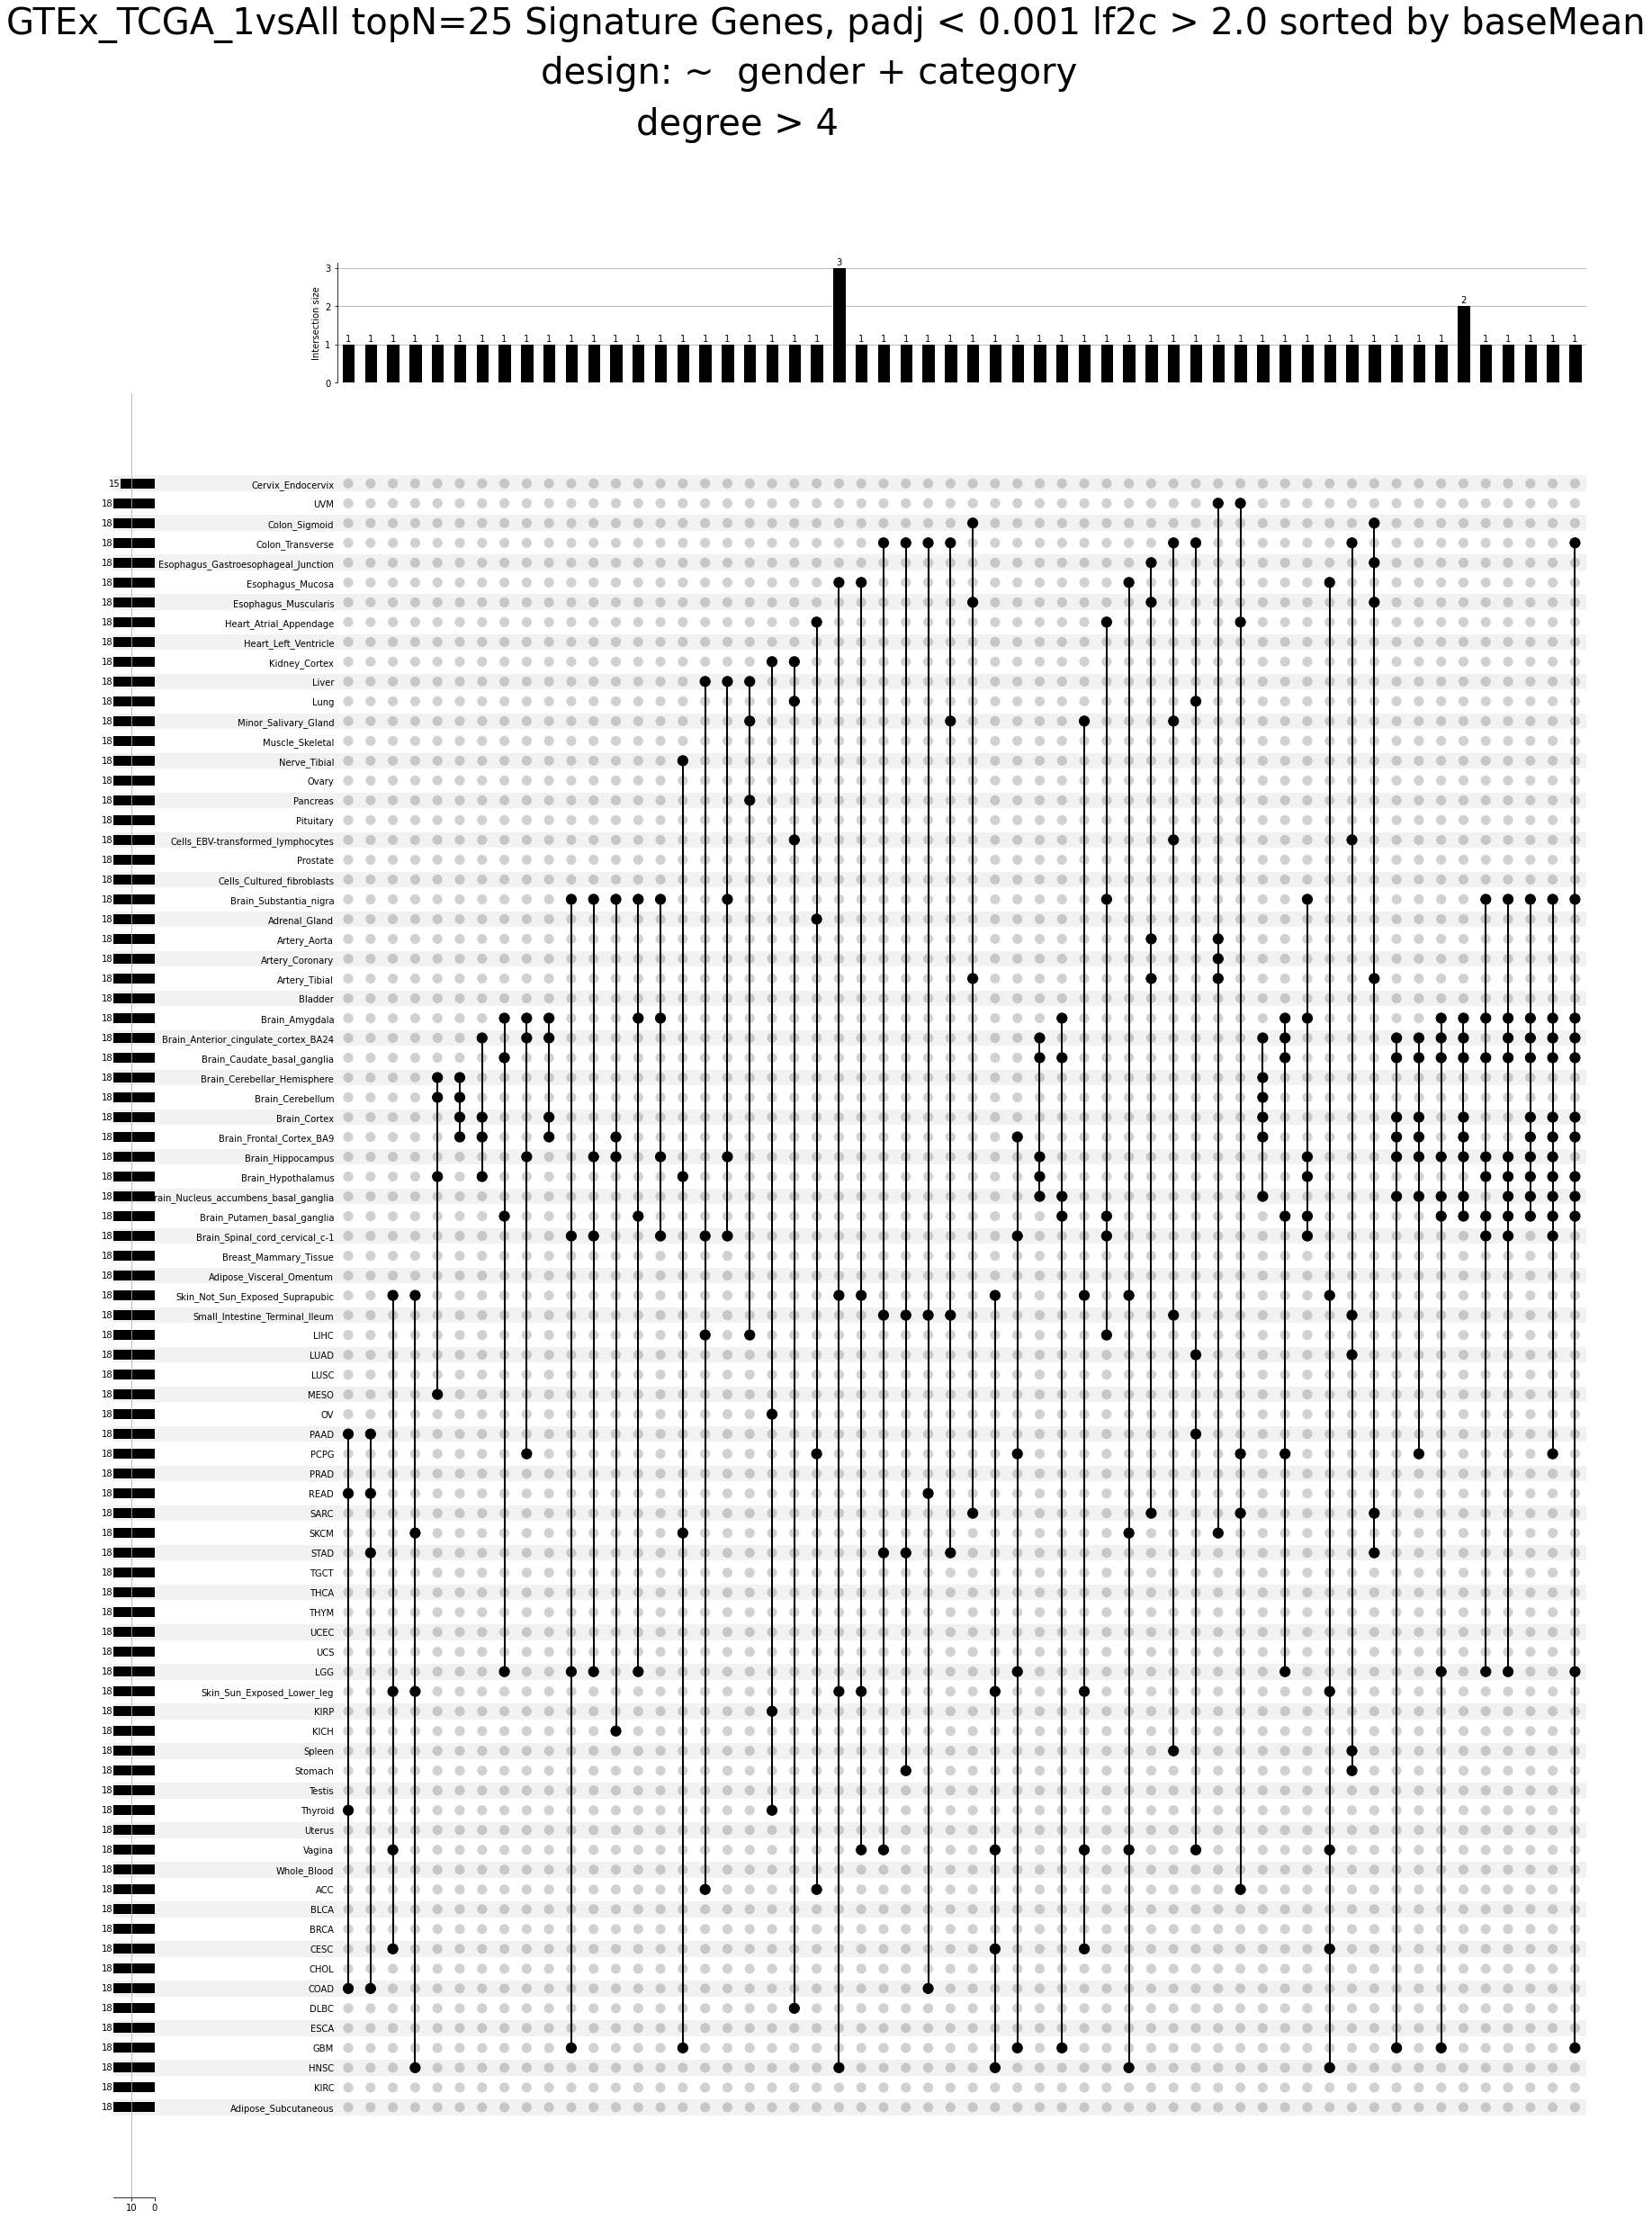

In [25]:

# 8, 7, 6, 5, 4, works in power point
pltDict = upsp.UpSet(geneSetsUpsetPlotData, show_counts=True, min_degree=4).plot()
fig = plt.gcf()
title = signatureGeneConfig.title
fig.suptitle( title, fontsize=40 ) 

# figureWidthInInches, figureHeightInInches = fig.get_size_inches()
# print( figureWidthInInches ) # set_xlim
# print( figureHeightInInches)  # set_xlim

s="design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=s, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree > 4", fontsize=40)

cleanTitle =  title.replace(" ", "-") + ".png"
cleanTitle = cleanTitle.replace("<", "lt")
cleanTitle = cleanTitle.replace(">", "gt")
filePath = signatureGeneConfig.localCacheRoot + "/" + cleanTitle + ".png"

! rm $filePath 
print("saving to: {}".format(filePath))
fig.savefig(filePath, dpi=300, bbox_inches='tight', facecolor='white')

imgURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + cleanTitle
print("save to :\n{}".format(imgURL))
! gsutil cp $filePath $imgURL


In [26]:
def configurablePlot(geneSetsUpsetPlotData, **kwags):
    '''
    return 
        (fig, pltDict)
    
    allows you to pass extra upset plot variables
    examples
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4)
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4, max_degree=7)
    '''
    pltDict = upsp.UpSet(geneSetsUpsetPlotData,  **kwags).plot()
    fig = plt.gcf()
    title = signatureGeneConfig.title
    fig.suptitle( title, fontsize=40 ) 
    
    return (fig, pltDict)

In [27]:
def findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData):
    '''
    arguments:
        geneSetsDict
            key: set name
            value is a list of elements
        
        geneSetsUpsetPlotData:
            pandas multilevel index data frame. created from a function like upsetPlot from_contents()
            
    returns:
        retDict
            key: a comma separated list of set name
            value: the name of the elements in the intersection
            
        retSingleSetDict
            key: set name
            value: list of unique elements. elements not in any intersections
    '''
    retDict = dict()
    retSingleSetDict = dict()
    
    # convert list to numpy array so we can use fancy array index
    setNames = list(geneSetsUpsetPlotData.index.names)
    setNamesNP = np.asarray(setNames)
    
    # for each intersection 
    for idx in geneSetsUpsetPlotData.index.values:
        #print("\n********")
        arrayNP = np.asarray(idx)
        
        # get the list of sets that the intersection was formed from 
        setNameList = sorted( setNamesNP[arrayNP] )
        setList = list()
        for sn in setNameList:
            setList.append( geneSetsDict[sn] )
            
        if len(setList) > 1:
            intersection = set.intersection( *setList )
            #print(intersection)
            key = ",".join(setNameList)
            retDict[ key ] = intersection
            
    # find elements that are not in an intersection
    n = len(setNamesNP)
    for i in range(0, n):
        testSetName = setNamesNP[i]
        knockOut = [True]*n 
        knockOut[i] = False # the name to knock out
        unionSetNameList = setNamesNP[ knockOut ]
        
        unionSetList = list()
        for u in unionSetNameList:
            unionSetList.append( geneSetsDict[u] )
            
        union = set.union( *unionSetList )
        testSet = geneSetsDict[testSetName]
        intersection = testSet.difference(union)
        
        if len(intersection) > 0:
            retSingleSetDict[testSetName] = intersection 
            
    return (retDict, retSingleSetDict)

In [28]:
def savePlot(fig, intersectionElementsDict, extraFileNameParts):
    # remove chars that can not be used in file names
    baseName =  title.replace(" ", "-")
    baseName = baseName.replace("<", "lt")
    baseName = baseName.replace(">", "gt")
    baseName = baseName + "-" + extraFileNameParts
    
    # save png
    fileName = baseName + ".png"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName

    ! rm $filePath 
    print("saving to: {}".format(filePath))
    fig.savefig(filePath, dpi=300, bbox_inches='tight', facecolor='white')

    imgURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(imgURL))
    ! gsutil cp $filePath $imgURL    
    
    # the intersections
    
    # https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
    fileName =  baseName + ".intersection.dict"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName
    with open(filePath,'w') as data: 
      data.write(str(intersectionElementsDict))
    
    intersectionURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(intersectionURL))
    ! gsutil cp $filePath $intersectionURL   

saving to: output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-max_degree=1.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-max_degree=1.png
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-max_degree=1.png [Content-Type=image/png]...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-max_degree=1.intersection.dict
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,

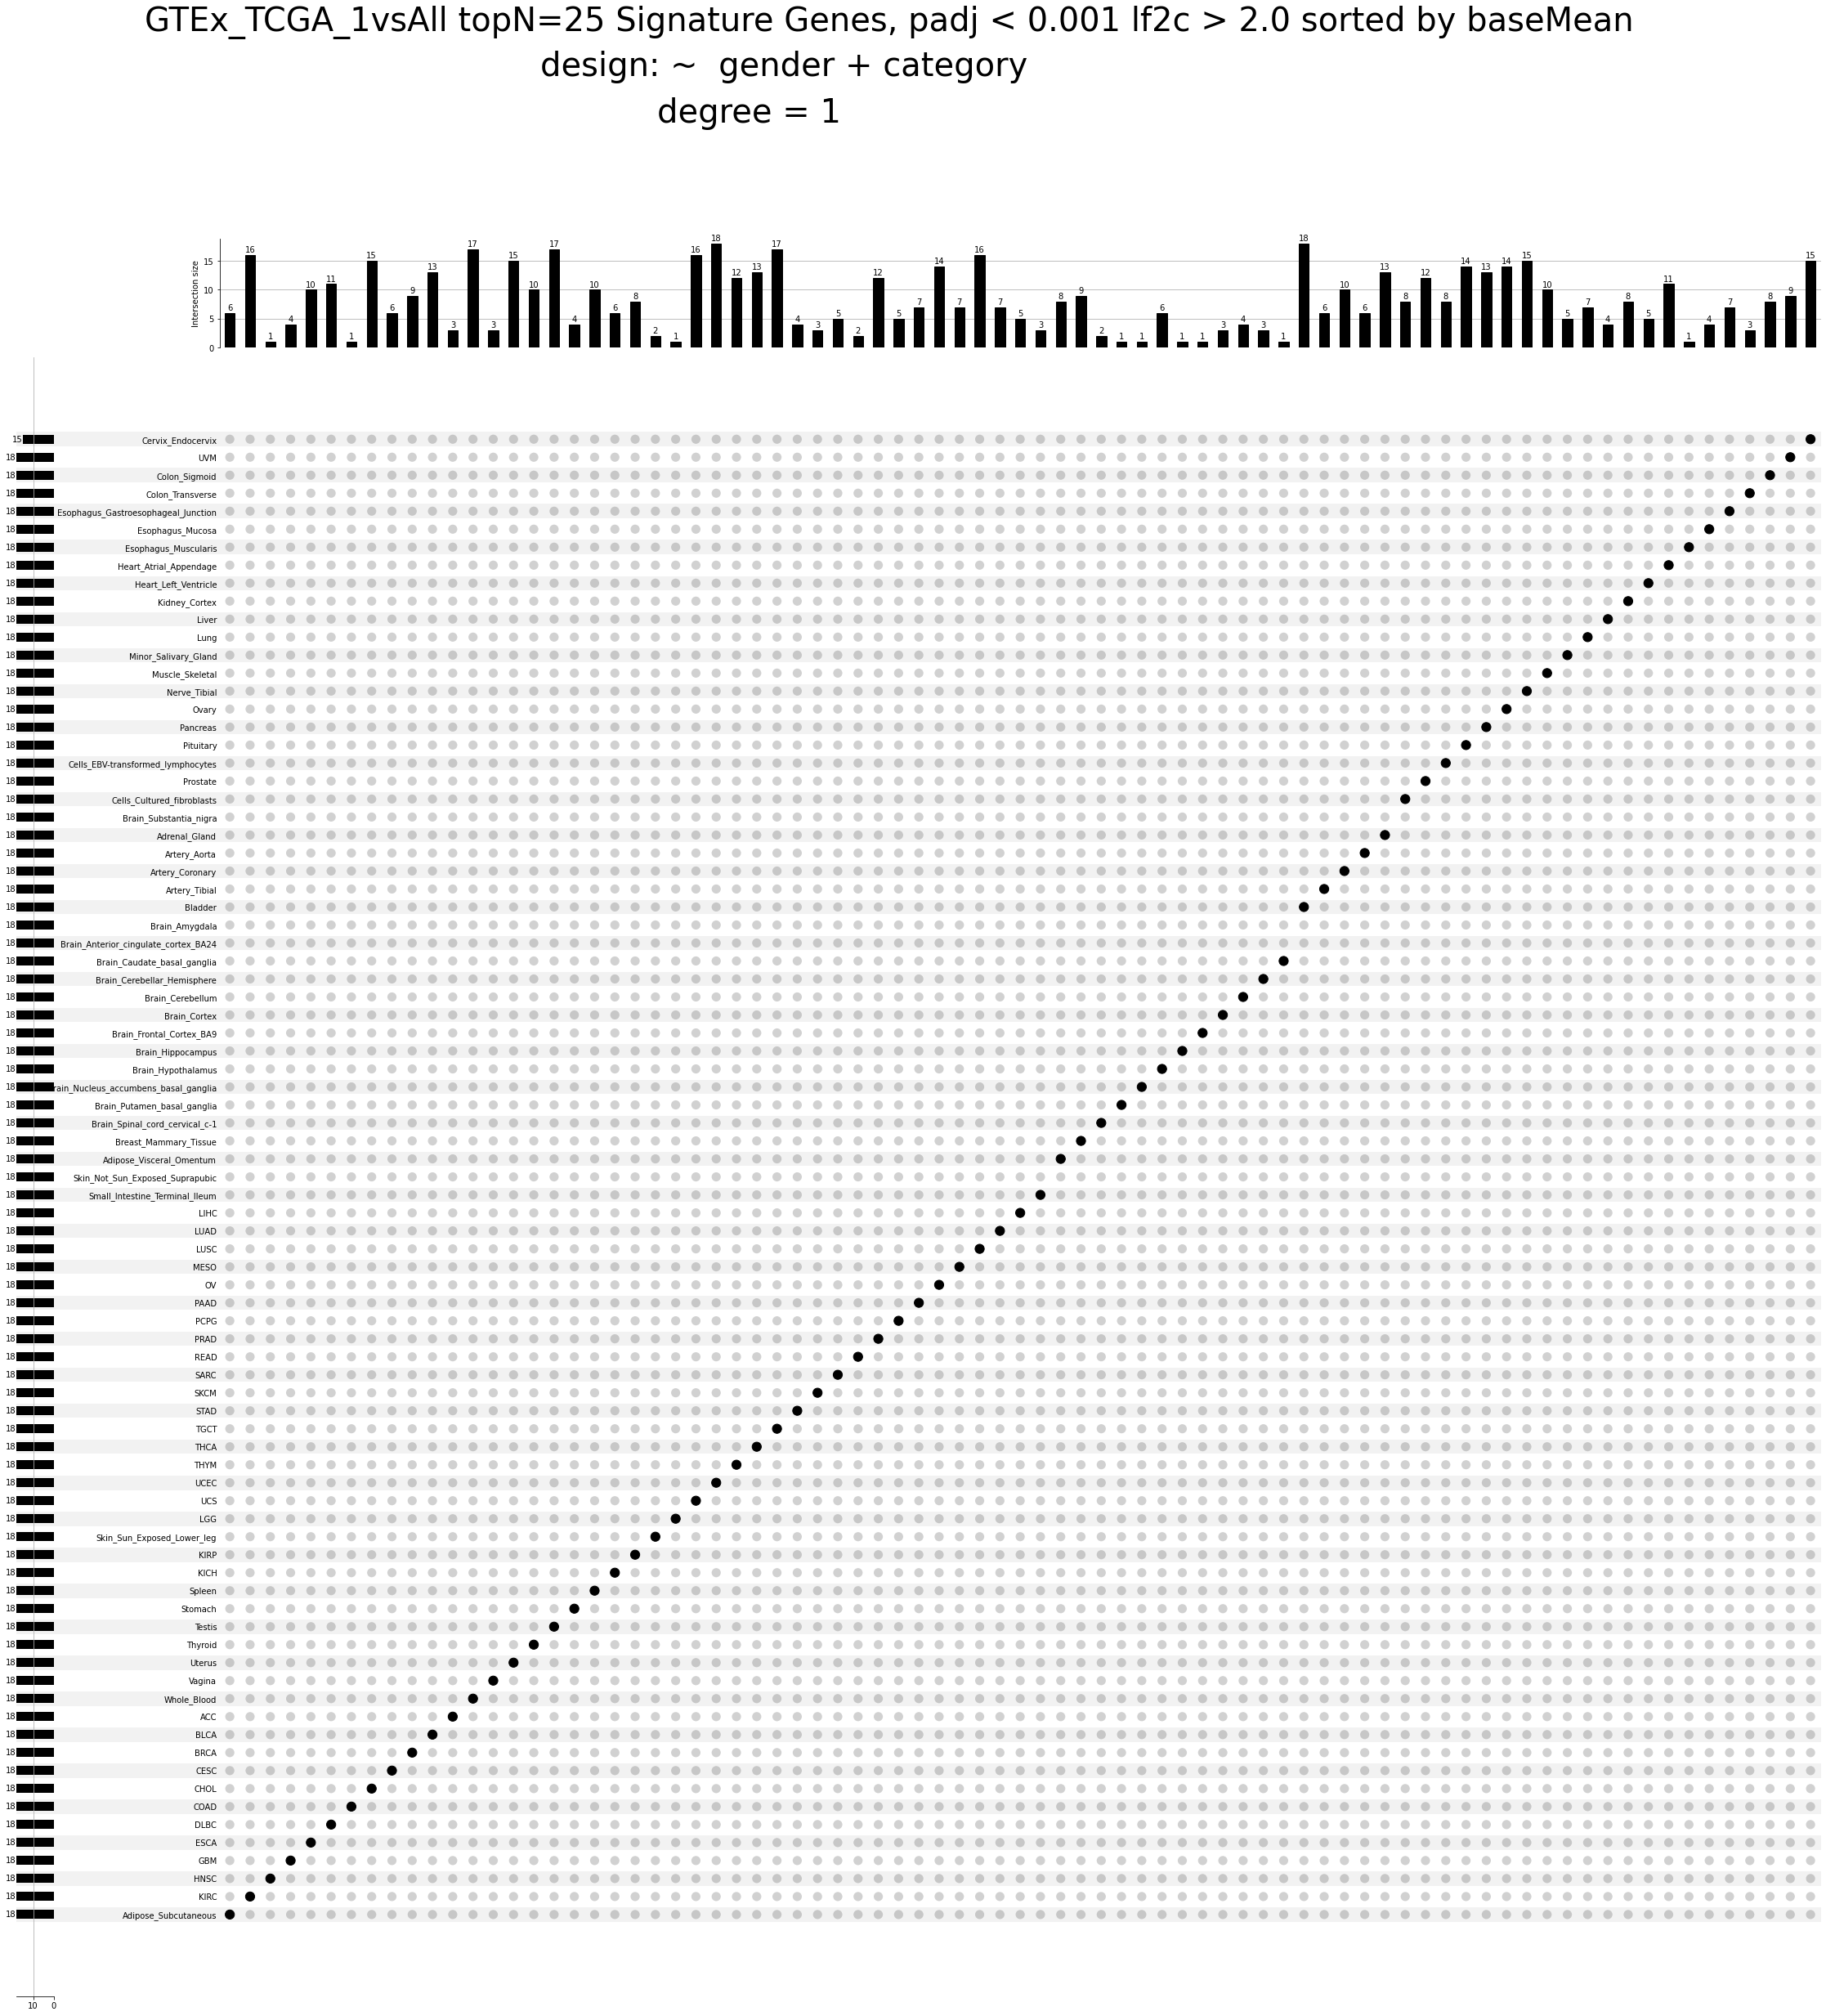

In [29]:
# create a plot sets of genes that are only found in one type
# use extra args to insure saved file name is unique
extraFileNameParts = 'max_degree=1'
fig, pltDict = configurablePlot(geneSetsUpsetPlotData, show_counts=True, max_degree=1)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree = 1", fontsize=40)

# for each interesection save teh list of sets in the intersection and the 
# intersection elements for down stream analysis
intersectionElementsDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)
intersectionElementsDict.update(retSingleSetDict)
savePlot(fig, intersectionElementsDict, extraFileNameParts)

In [30]:
# explore intersections
for setNames,elements in intersectionElementsDict.items():
    print("\nsetNames: \n{}".format(setNames.replace(",", ", ")))
    print("elements: \n{}".format(elements))    


setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, THYM
elements: 
{'BTNL9'}

setNames: 
Adipose_Subcutaneous, LUSC
elements: 
{'AKR1C2'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, KIRP
elements: 
{'GPD1'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, Breast_Mammary_Tissue
elements: 
{'ADIPOQ'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, GBM
elements: 
{'LPL'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum
elements: 
{'ADIPOQ', 'LPL', 'ACACB', 'APOLD1', 'SPRY1', 'AGPAT2', 'CD36', 'FZD4'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue
elements: 
{'BTNL9', 'GPD1', 'PLIN1', 'ADIPOQ'}

setNames: 
Adipose_Visceral_Omentum, MESO
elements: 
{'TM4SF1'}

setNames: 
Adipose_Visceral_Omentum, Adrenal_Gland
elements: 
{'MGST1'}

setNames: 
ACC, Adrenal_Gland, Heart_Atrial_Appendage, PCPG
elements: 
{'C7'}

setNames: 
ACC, Adrenal_Gland
elements: 
{'C7', 'EPHX1'}

setNames: 
Adrenal_Gland, Ovary, Pituitary
elements: 
{'DLK1'}

s

saving to: output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=2,max_degree=3.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=2,max_degree=3.png
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=2,max_degree=3.png [Content-Type=image/png]...
/ [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=2,max_degree=3.intersection.dict
Copying fil

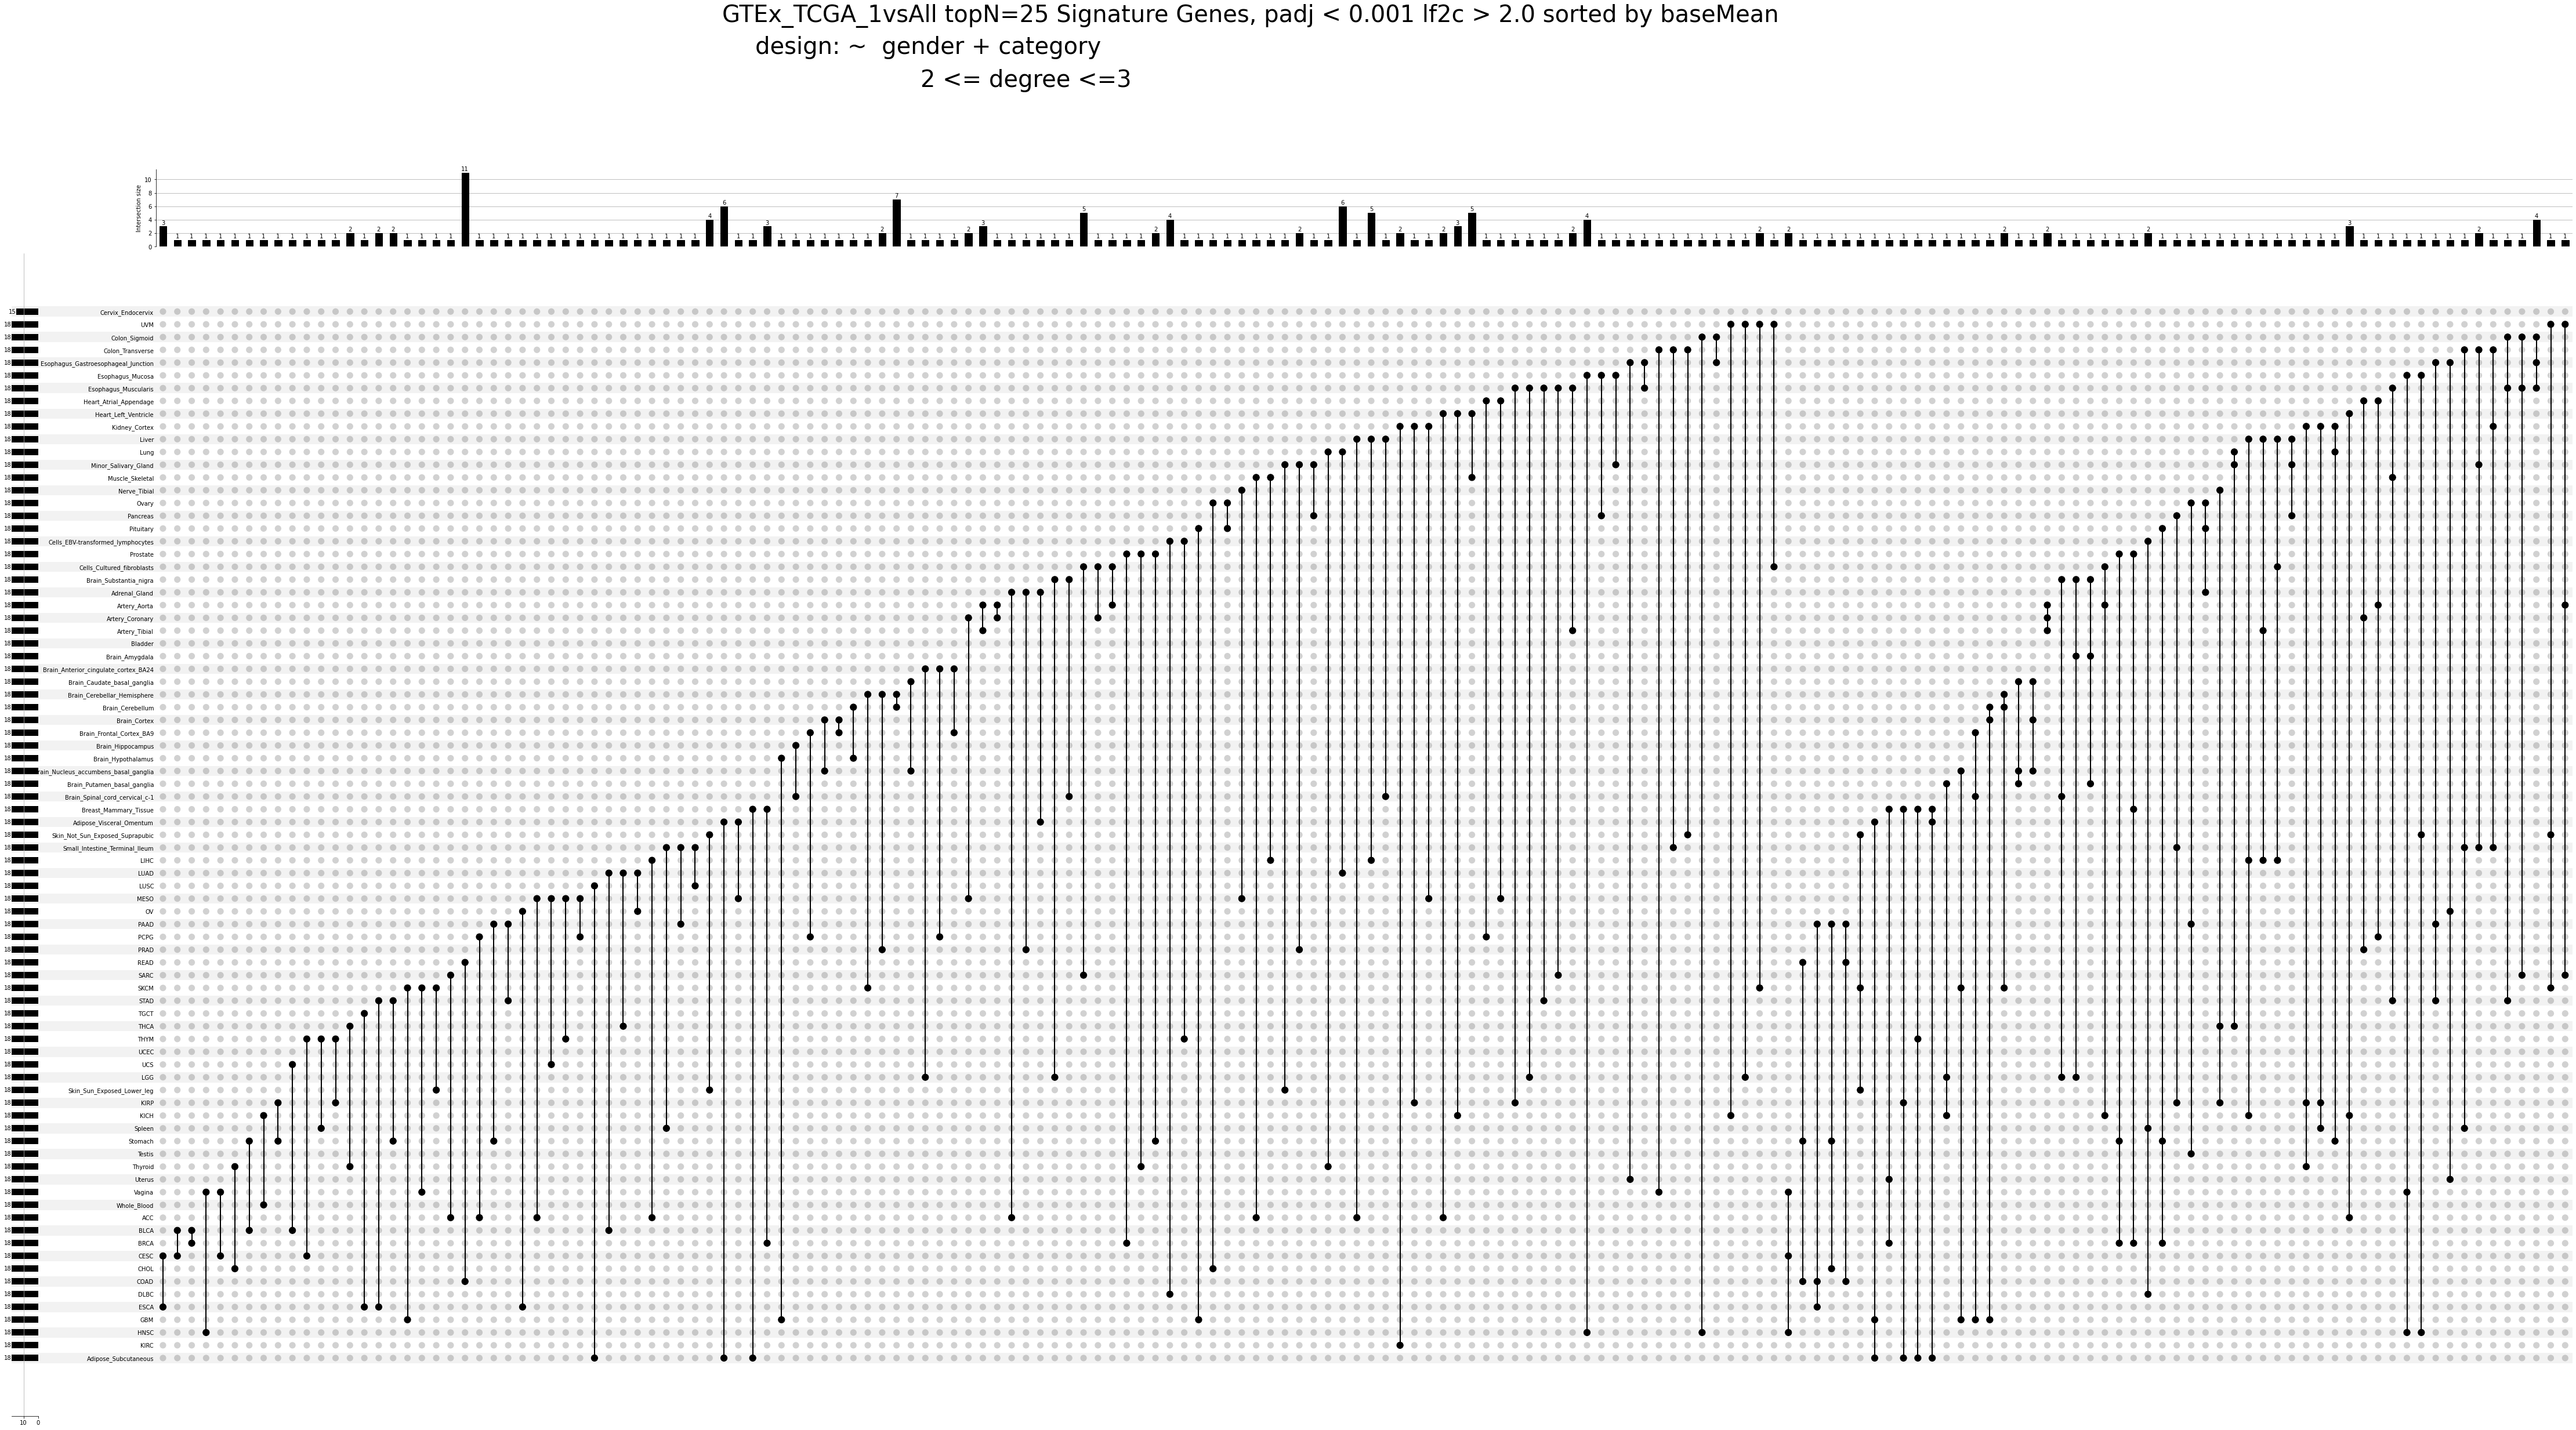

In [31]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=2,max_degree=3'
fig, pltDict = configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=2, max_degree=3)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="2 <= degree <=3", fontsize=40)

# for each interesection save teh list of sets in the intersection and the 
# intersection elements for down stream analysis
intersectionElementsDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)
intersectionElementsDict.update(retSingleSetDict)
savePlot(fig, intersectionElementsDict, extraFileNameParts)

In [32]:
# explore intersections
for setNames,elements in intersectionElementsDict.items():
    print("\nsetNames: \n{}".format(setNames.replace(",", ", ")))
    print("elements: \n{}".format(elements))    


setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, THYM
elements: 
{'BTNL9'}

setNames: 
Adipose_Subcutaneous, LUSC
elements: 
{'AKR1C2'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, KIRP
elements: 
{'GPD1'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, Breast_Mammary_Tissue
elements: 
{'ADIPOQ'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, GBM
elements: 
{'LPL'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum
elements: 
{'ADIPOQ', 'LPL', 'ACACB', 'APOLD1', 'SPRY1', 'AGPAT2', 'CD36', 'FZD4'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue
elements: 
{'BTNL9', 'GPD1', 'PLIN1', 'ADIPOQ'}

setNames: 
Adipose_Visceral_Omentum, MESO
elements: 
{'TM4SF1'}

setNames: 
Adipose_Visceral_Omentum, Adrenal_Gland
elements: 
{'MGST1'}

setNames: 
ACC, Adrenal_Gland, Heart_Atrial_Appendage, PCPG
elements: 
{'C7'}

setNames: 
ACC, Adrenal_Gland
elements: 
{'C7', 'EPHX1'}

setNames: 
Adrenal_Gland, Ovary, Pituitary
elements: 
{'DLK1'}

s

saving to: output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=4.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=4.png
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=4.png [Content-Type=image/png]...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/up/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-topN=25-Signature-Genes,-padj-lt-0.001-lf2c-gt-2.0-sorted-by-baseMean-min_degree=4.intersection.dict
Copying file://output/GTEx_TCGA_1vsAll-topN=25-Signature-Genes,

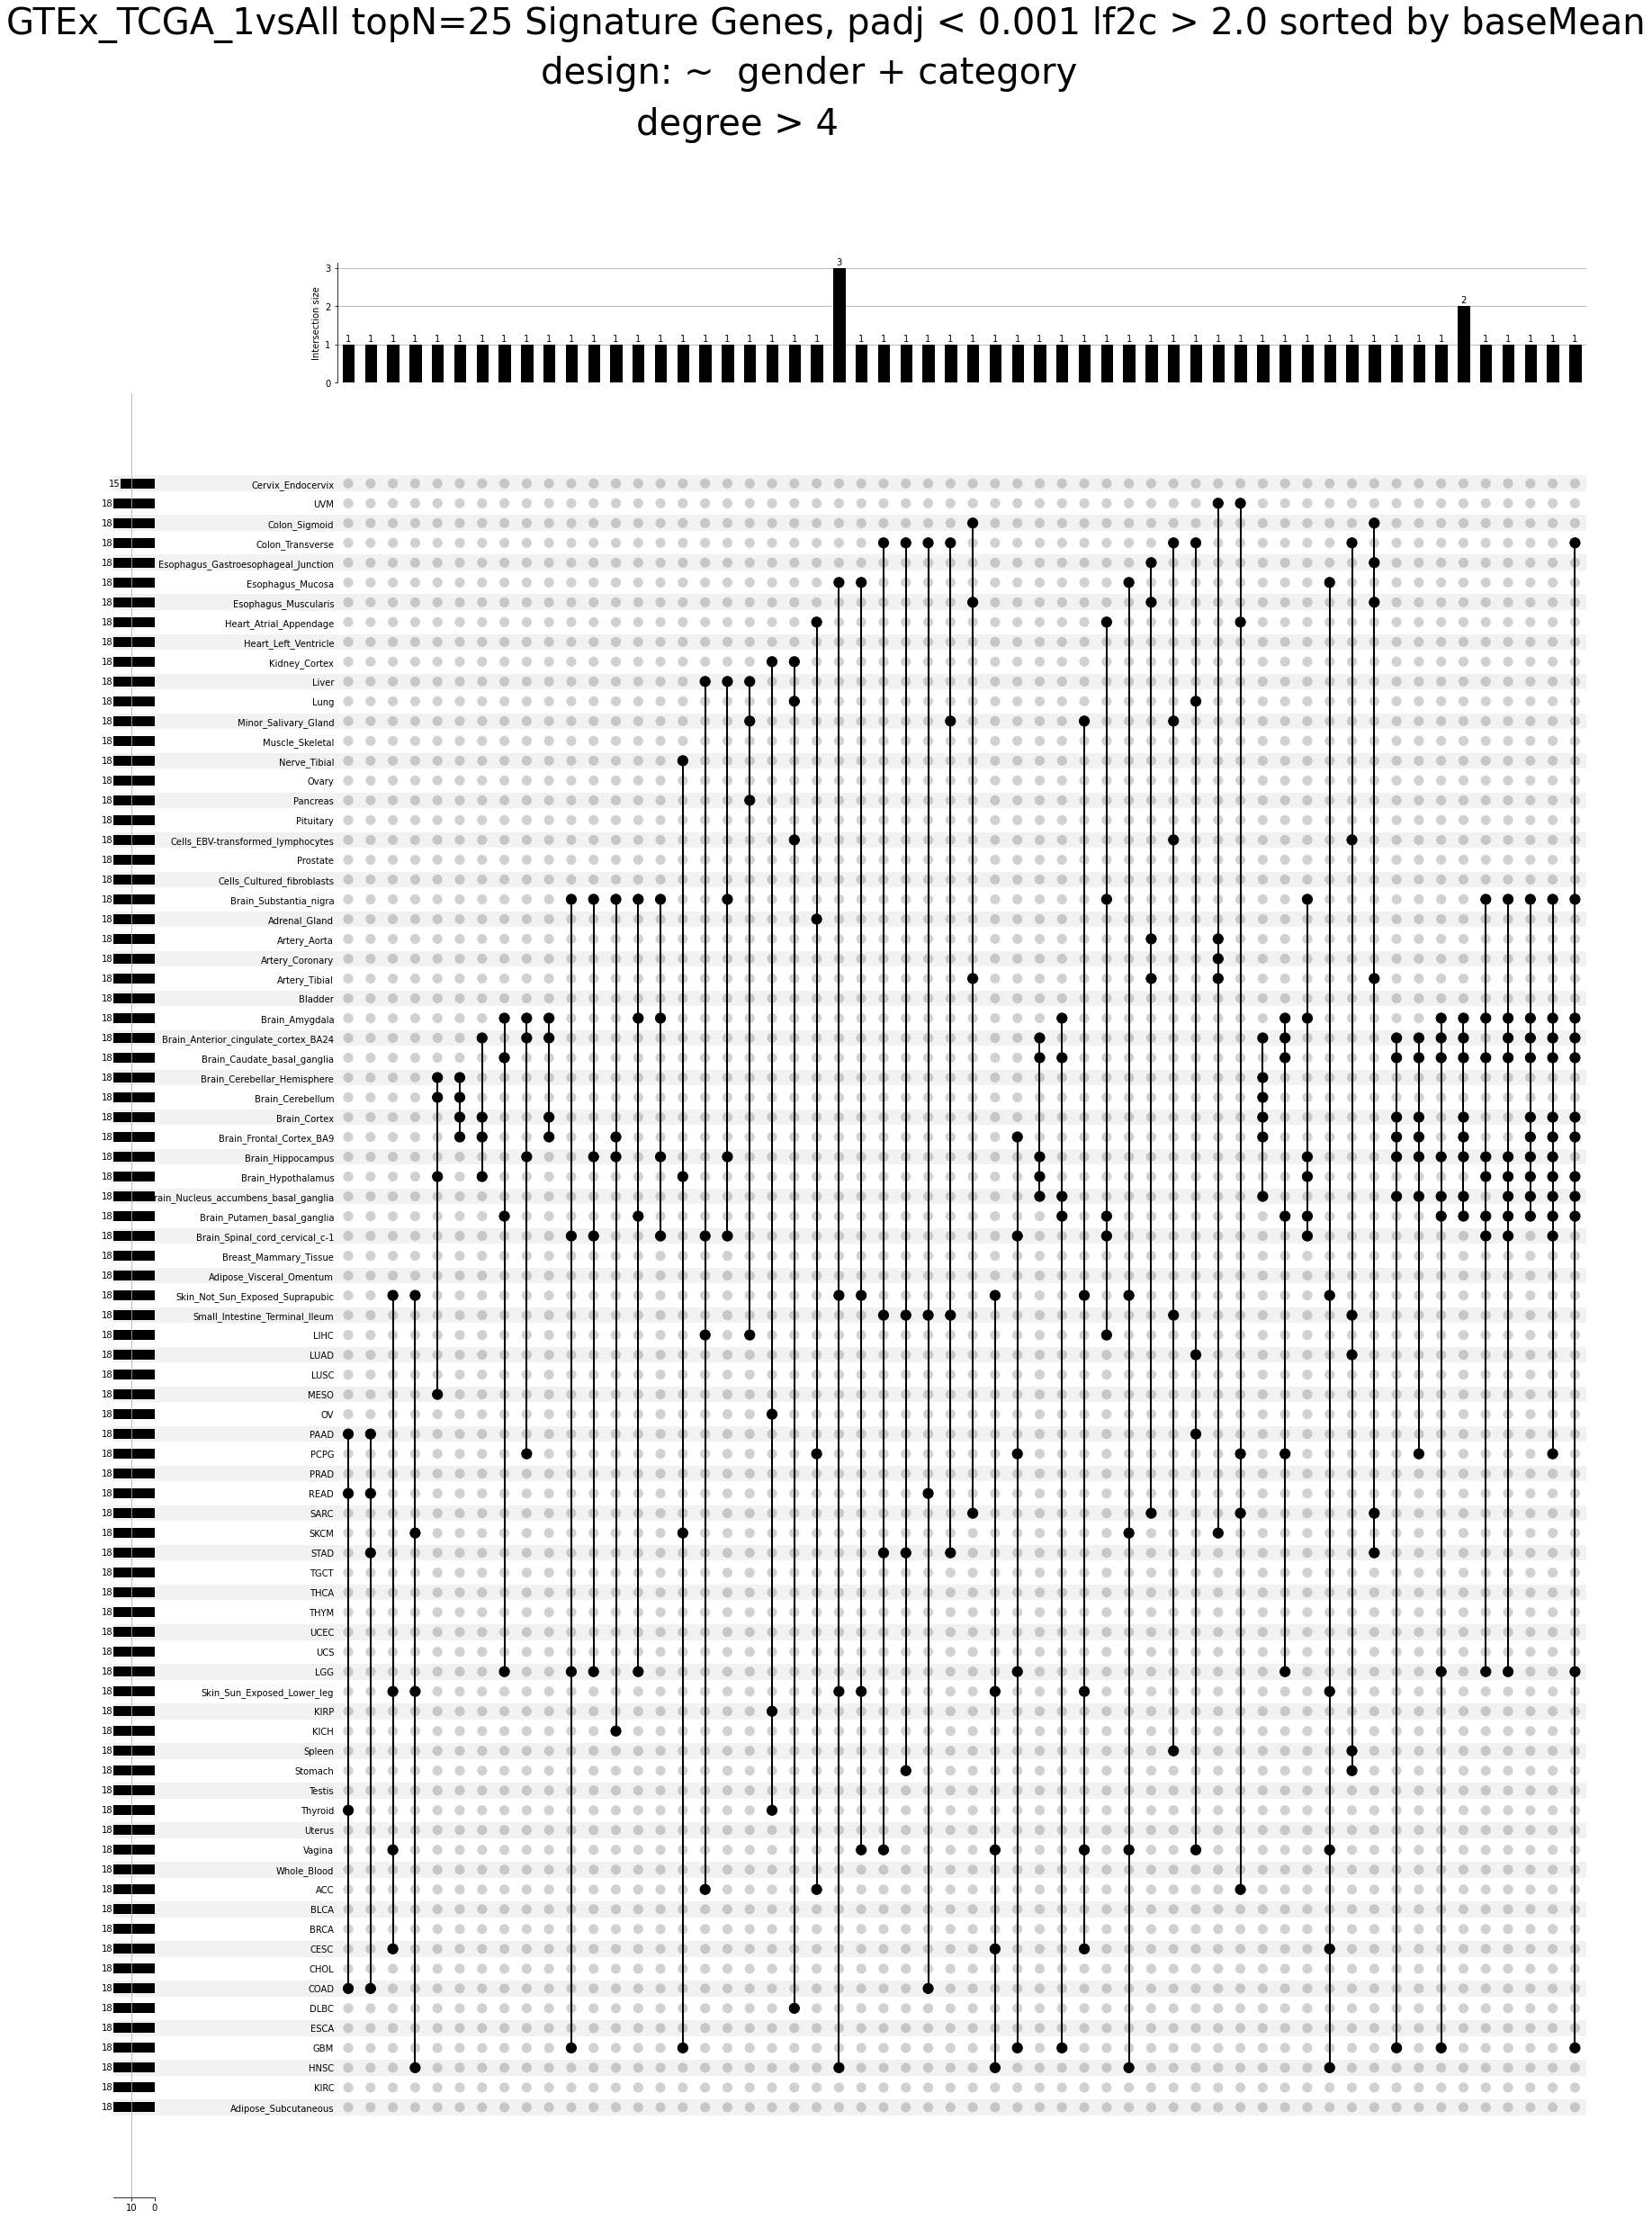

In [33]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=4'
fig, pltDict = configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree > 4", fontsize=40)

# for each interesection save teh list of sets in the intersection and the 
# intersection elements for down stream analysis
intersectionElementsDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)
intersectionElementsDict.update(retSingleSetDict)
savePlot(fig, intersectionElementsDict, extraFileNameParts)

In [34]:
# explore intersections
for setNames,elements in intersectionElementsDict.items():
    print("\nsetNames: \n{}".format(setNames.replace(",", ", ")))
    print("elements: \n{}".format(elements))    


setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, THYM
elements: 
{'BTNL9'}

setNames: 
Adipose_Subcutaneous, LUSC
elements: 
{'AKR1C2'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue, KIRP
elements: 
{'GPD1'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, Breast_Mammary_Tissue
elements: 
{'ADIPOQ'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum, GBM
elements: 
{'LPL'}

setNames: 
Adipose_Subcutaneous, Adipose_Visceral_Omentum
elements: 
{'ADIPOQ', 'LPL', 'ACACB', 'APOLD1', 'SPRY1', 'AGPAT2', 'CD36', 'FZD4'}

setNames: 
Adipose_Subcutaneous, Breast_Mammary_Tissue
elements: 
{'BTNL9', 'GPD1', 'PLIN1', 'ADIPOQ'}

setNames: 
Adipose_Visceral_Omentum, MESO
elements: 
{'TM4SF1'}

setNames: 
Adipose_Visceral_Omentum, Adrenal_Gland
elements: 
{'MGST1'}

setNames: 
ACC, Adrenal_Gland, Heart_Atrial_Appendage, PCPG
elements: 
{'C7'}

setNames: 
ACC, Adrenal_Gland
elements: 
{'C7', 'EPHX1'}

setNames: 
Adrenal_Gland, Ovary, Pituitary
elements: 
{'DLK1'}

s